**Introduction:** 

On April 14th, 1912, the Titanic, which was the most advanced ship at the time, hit an iceberg and sank (History.com). Though there were 16 lifeboats that could hold a maximum of 1178 people, out of the 2208 passengers on board, only 705 survived (Barrratt 2009). There were three classes and three different resulting fare values for First, Second, and Third class. Third class made up the majority of the passengers with 709 people, but when the Titanic sank, three-quarters of them died in comparison to those in First and Second Class (Person 2011). Therefore our question is given the age, and fare value of the passenger, can we determine if they would have survived or not? The dataset we will be using is a tabular data set with comma-separated variables. It has 10 variables but out of the 10 we will be using three; Survived, Age, and Fare, in order to answer our question.

**Preliminary exploratory data analysis:**

In [40]:
library(tidyverse)
library(repr)
library(tidymodels)
library(forcats)
library(broom)
options(repr.matrix.max.rows = 6)

In [41]:
train <- read_csv("train.csv") %>% mutate(Survived = as_factor(Survived), DirectRelatives = SibSp + Parch) %>% mutate(across(where(is.numeric),scale)) %>%  drop_na(-Cabin)
summary(train)

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Survived = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)



    PassengerId.V1    Survived      Pclass.V1           Name          
 Min.   :-1.7291368   0:424    Min.   :-1.5652278   Length:712        
 1st Qu.:-0.8674827   1:288    1st Qu.:-1.5652278   Class :character  
 Median :-0.0038857            Median :-0.3691575   Mode  :character  
 Mean   : 0.0100635            Mean   :-0.0818990                     
 3rd Qu.: 0.8985683            3rd Qu.: 0.8269128                     
 Max.   : 1.7291368            Max.   : 0.8269128                     
     Sex                  Age.V1             SibSp.V1            Parch.V1      
 Length:712         Min.   :-2.015566   Min.   :-0.474279   Min.   :-0.473408  
 Class :character   1st Qu.:-0.667685   1st Qu.:-0.474279   1st Qu.:-0.473408  
 Mode  :character   Median :-0.116967   Median :-0.474279   Median :-0.473408  
                    Mean   :-0.003926   Mean   :-0.008128   Mean   : 0.063259  
                    3rd Qu.: 0.571430   3rd Qu.: 0.432550   3rd Qu.: 0.767199  
                    Max

The dataset uses the following columns:
<ul>
    <li><em>"PassengerId"</em>: Unique identifier for passengers</li>
    <li><em>"Survived"</em>: Class we are trying to predict, 1=Survived, 2=Passed</li>
    <li><em>"Sex"</em>: Male or Female</li>
    <li><em>"Age"</em>: Age in years(Predictor 1)</li>
    <li><em>"SibSp"</em>: Number of siblings / spouses aboard</li>
    <li><em>"Parch"</em>: Number of parents / children aboard</li>
    <li><em>"Ticket"</em>: Ticket number</li>
    <li><em>"Fare"</em>: Passenger fare (Predictor 2)</li>
    <li><em>"Cabin"</em>: Cabin number</li>
    <li><em>"Embarked"</em>: Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)</li>
    <li><em>"DirectRelatives"</em>: SibSp + Parch</li>
</ul>

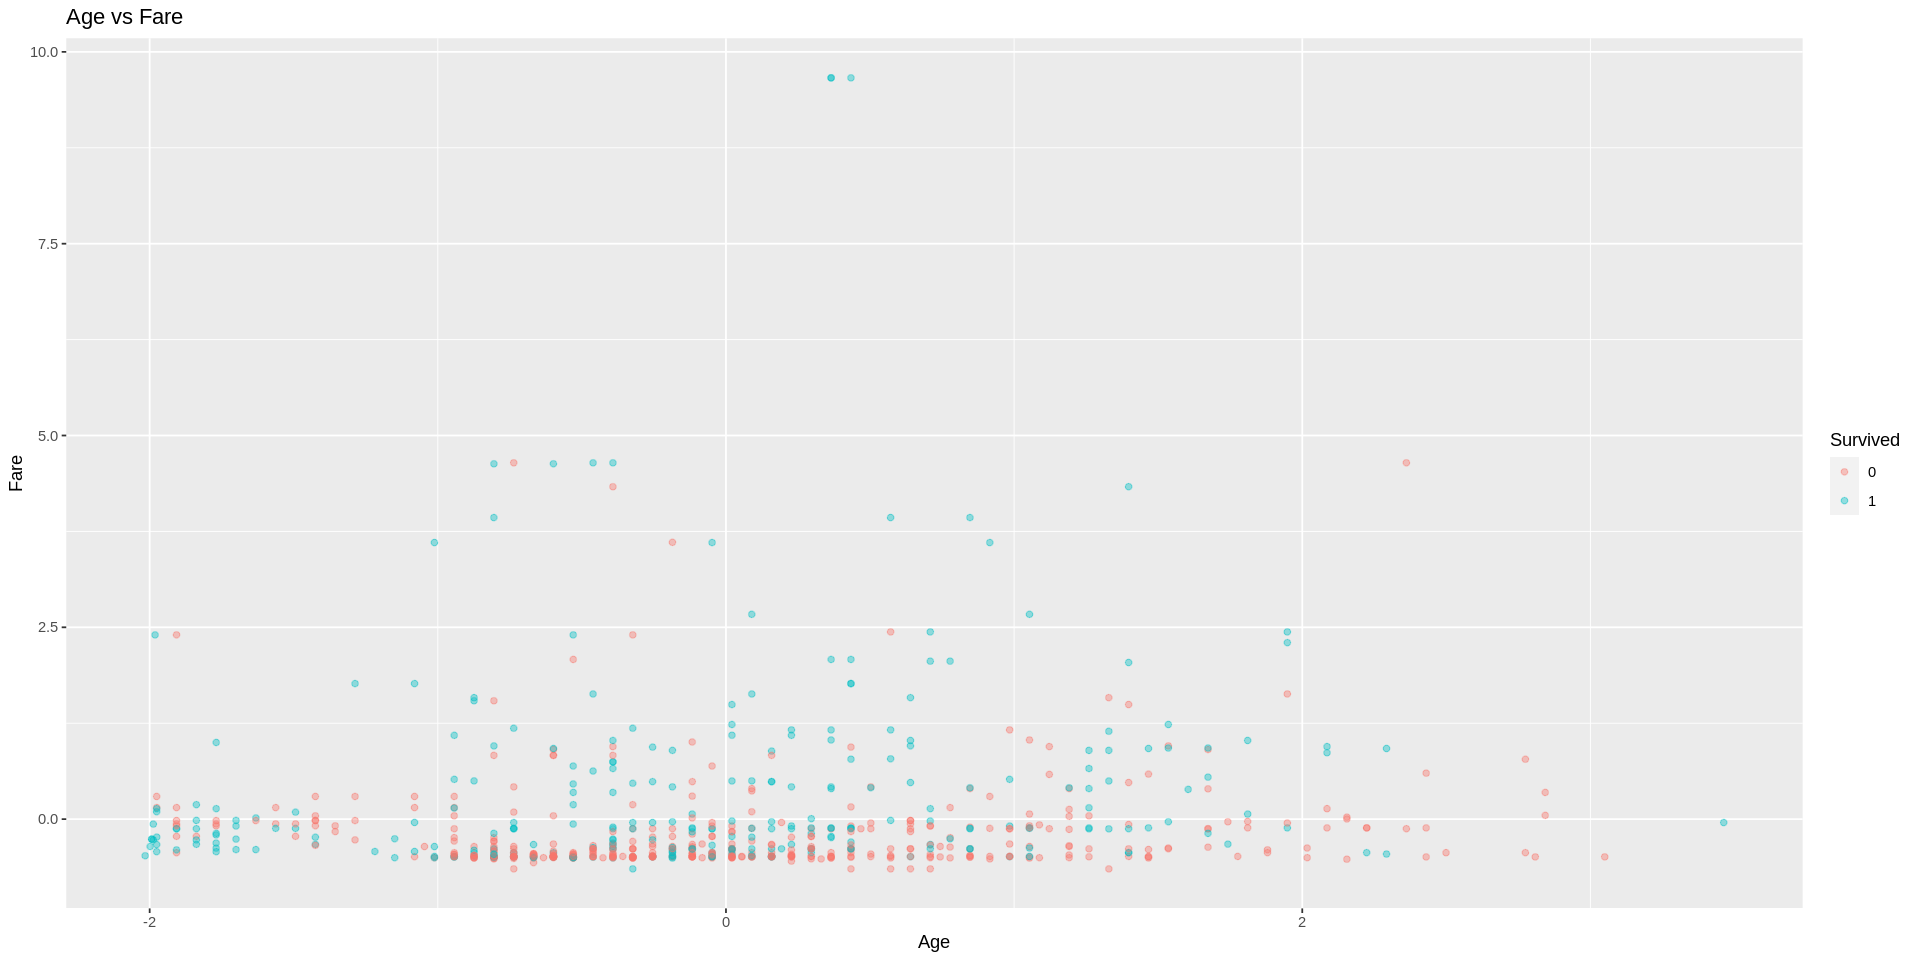

In [42]:
options(repr.plot.width = 16, repr.plot.height = 8) 
train %>% ggplot(aes(x = Age, y =  Fare, colour=Survived)) + 
           geom_point(alpha = 0.4) +
           xlab("Age") +
           ylab("Fare") +
           ggtitle("Age vs Fare")

**Methods**: 

For columns, we choose age, sex, fare, and survived because using age and fare information can determine or compare whether the passenger survived or not. In addition, using the KNN classifies our question, making Tibble and graph simpler to comprehend. For example, we might be attempting to predict whether the passengers on the Titanic survived (1 or 0) depending on their age. We also will stratify Titanic data by sex, ensuring that the same proportion of men and woman is included in both the training and testing sets ( Timbers et al., 2022).  Using three scatter plots, explore the distributions of two variables (age and survived/ sex and survived/ fare and survived) to observe relationships between them. Positive or negative relationships, strong or weak correlations and non-linear or linear relationships can all be detected in the scatter plot.

**Expected Outcomes**: 

From the scatter plot, we could conclude that passengers with higher fares, younger age in both genders, and middle-aged women are likely to survive. This phenomenon reflects the reality of social inequality and the vulnerability of children and women. Higher fares increase the survival chance as they tend to have more incomes and power; not saving them may even put the rescuer into trouble since those people have an excellent background to support them. Plus, children and women are a priority to save since they need more assistance to survive in a disaster, unlike males with a strong ability to respond to an emergency. With over a thousand deaths on the Titanic, this leads us to brainstorm  what evacuation procedures are safer to increase the chance of survival in similar accidents. 

**References:** 

Barratt, Nick (2009). Lost Voices From the Titanic: The Defi History. London: Random House. p. 93. ISBN 978-1-84809-151-1.

History.com Editors. “Titanic.” History.com, A&E Television Networks, 9 Nov. 2009, www.history.com/topics/early-20th-century-us/titanic#section_1.

Timbers,Tiffany. Campbell, Trevor and Lee, Melissa. Data Science: A First Introduction.\

Person. “Titanic Anniversary: Remembering the Third-Class Passengers.” ABC13 Houston, KTRK-TV, 11 Apr. 2021, abc13.com/titanic-anniversary-immigration-world-history/1874040/#:~:text=Approximately 1,317 passengers died when,their area of the Titanic

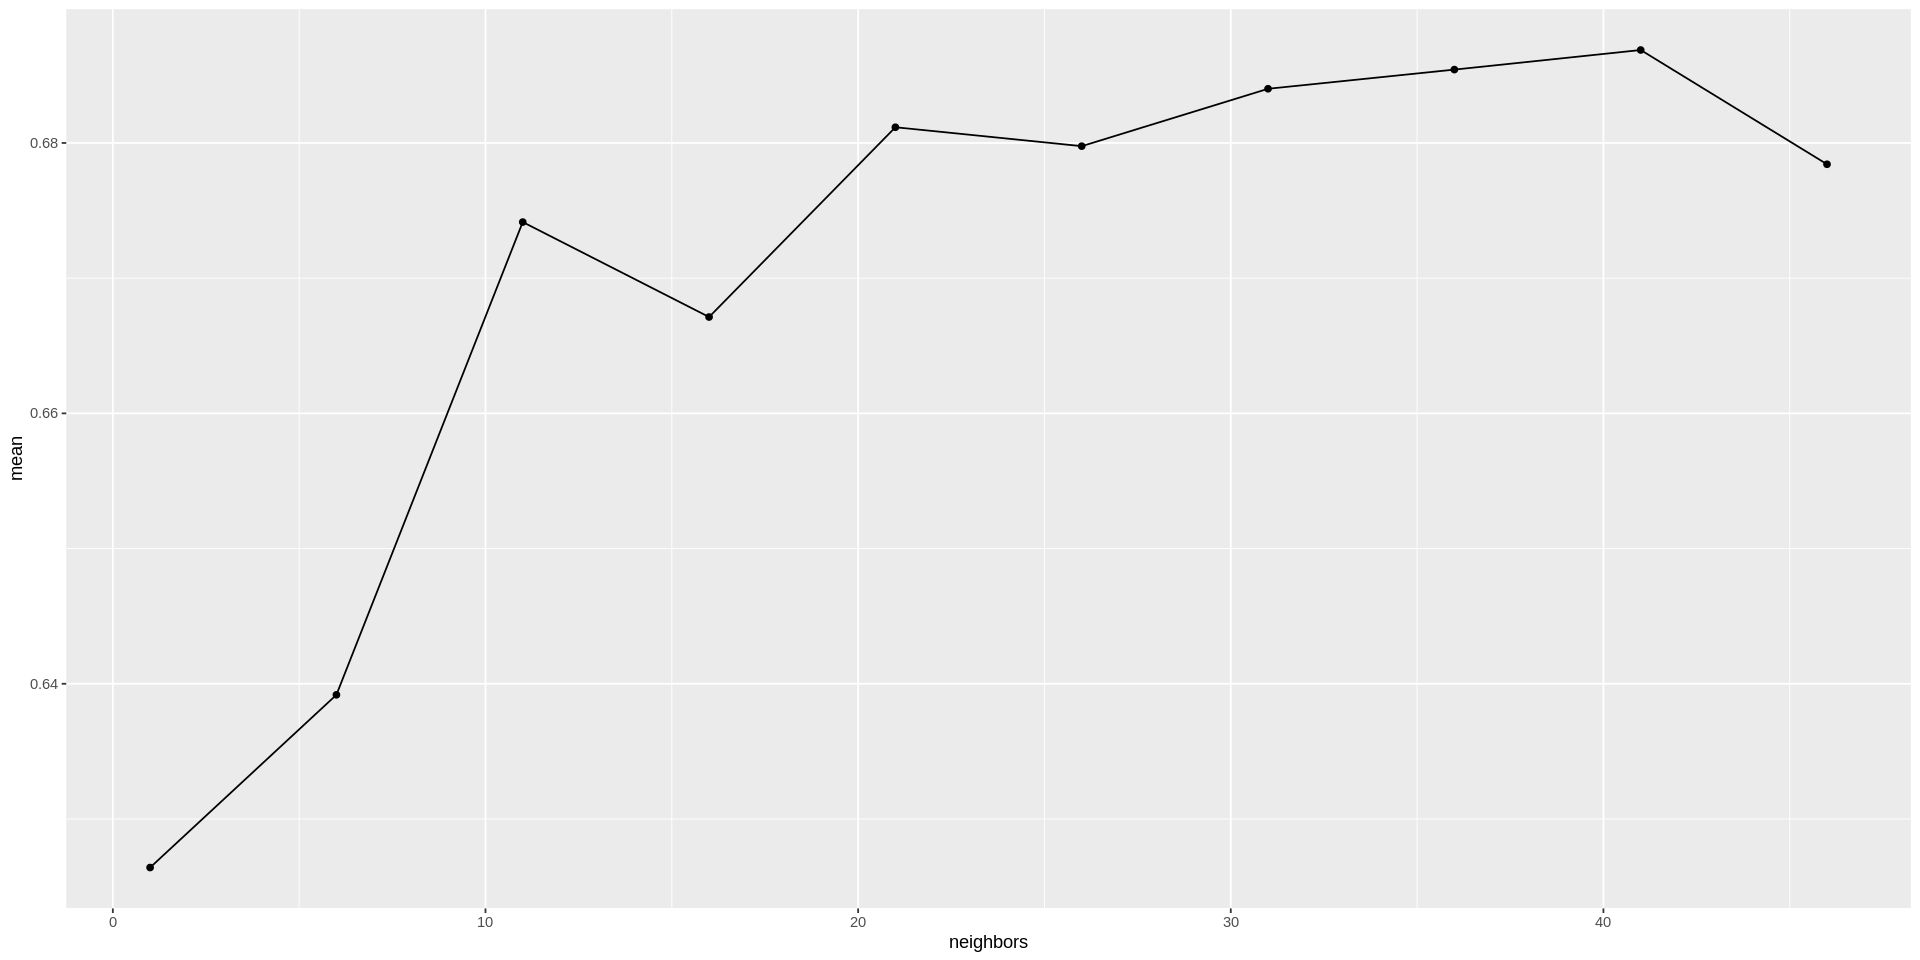

In [53]:
set.seed(2020) # DO NOT REMOVE

recipe <- recipe(Survived ~ Age + Fare , data = train) %>%
   step_scale(all_predictors()) %>%
    step_center(all_predictors())
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
the_vfold <- vfold_cv(train, v = 5, strata = Survived)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))
results <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = the_vfold, grid = k_vals) %>%
      collect_metrics()
results %>% filter(.metric == "accuracy") %>%
                ggplot(aes(x=neighbors, y=mean))+ geom_point() + geom_line()


In [54]:
# train_cluster <- augment(kmeans(only_predictors, centers = 4),only_predictors)
# train_cluster %>% ggplot(aes(x = Age, y =  Fare, color=.cluster)) + 
#            geom_point(alpha = 0.4) +
#            labs(x ="Age", y= "Fare", colour = "Cluster")
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 41) %>%
      set_engine("kknn") %>%
      set_mode("classification")
best_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(best_spec) %>%
        fit(data=train)
test <- read_csv("test.csv") %>% mutate(DirectRelatives = SibSp + Parch) %>% mutate(across(where(is.numeric),scale)) %>%  drop_na(-Cabin)
predictions <- predict(best_fit,test) %>% bind_cols(test)

Parsed with column specification:
cols(
  PassengerId = col_double(),
  Pclass = col_double(),
  Name = col_character(),
  Sex = col_character(),
  Age = col_double(),
  SibSp = col_double(),
  Parch = col_double(),
  Ticket = col_character(),
  Fare = col_double(),
  Cabin = col_character(),
  Embarked = col_character()
)



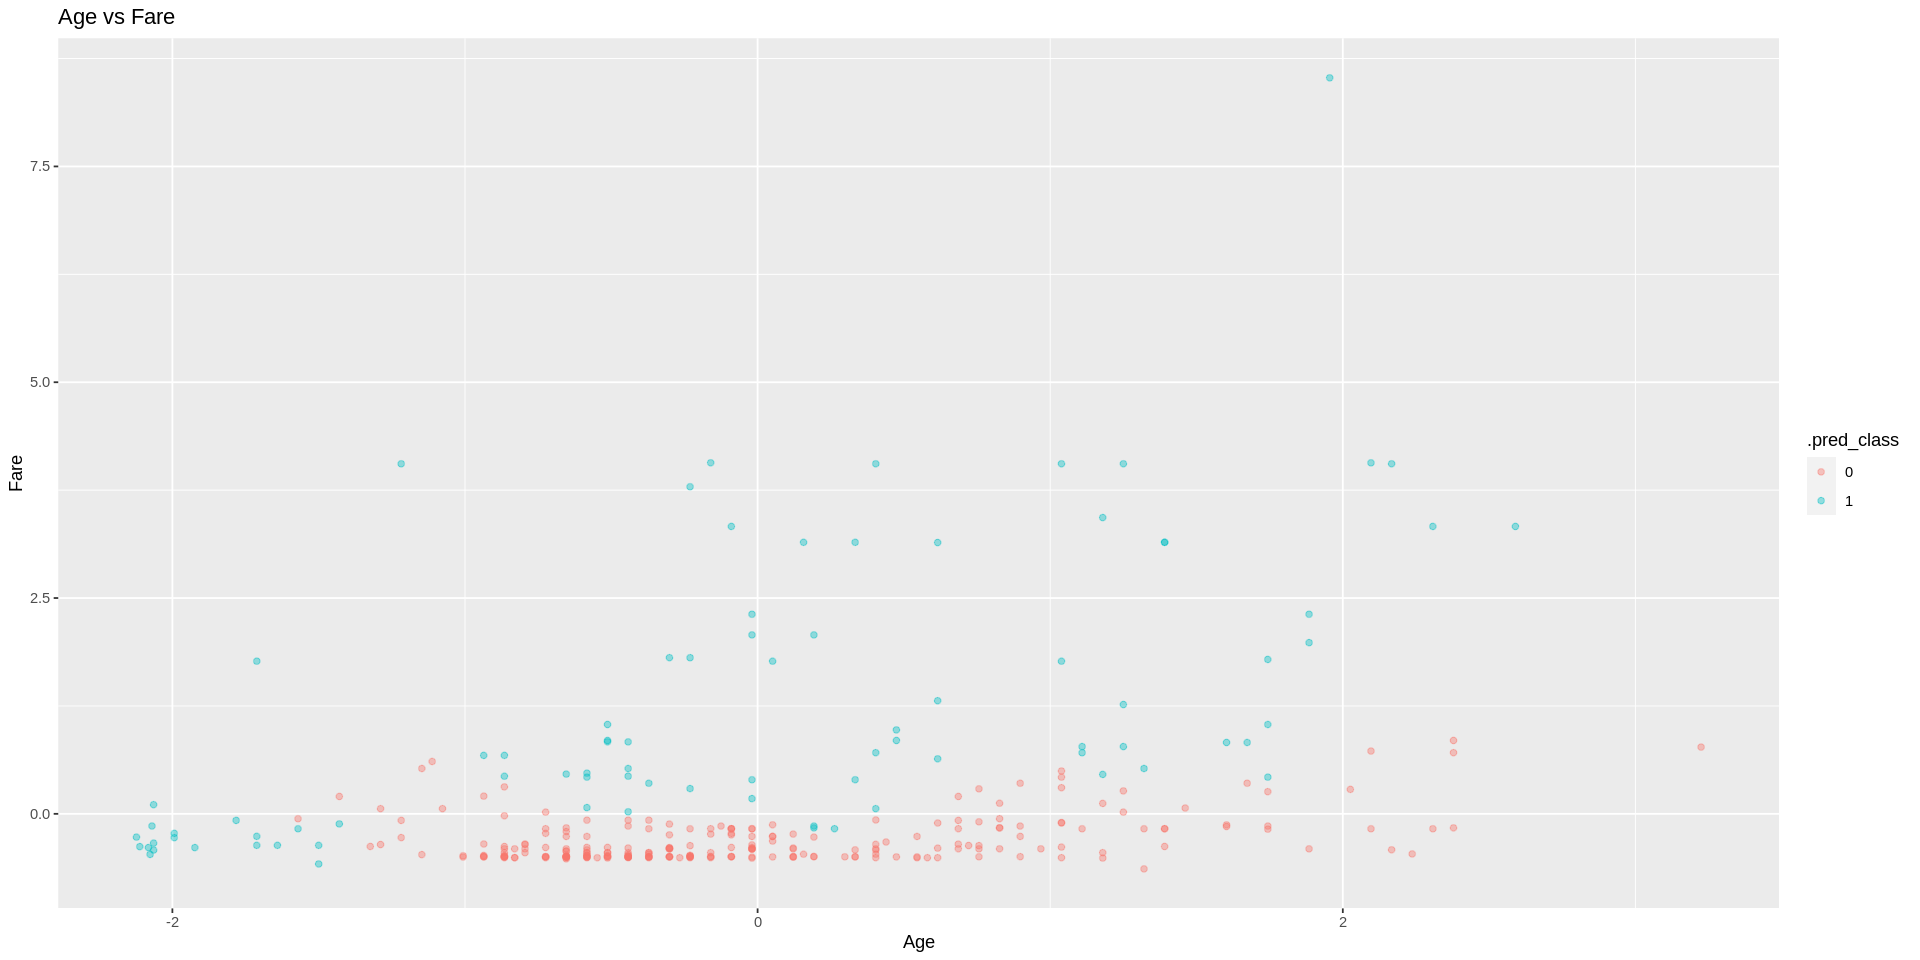

In [55]:
predictions %>% ggplot(aes(x = Age, y =  Fare, colour=.pred_class)) + 
           geom_point(alpha = 0.4) +
           xlab("Age") +
           ylab("Fare") +
           ggtitle("Age vs Fare")

The results support the popular notion that the richer passengers(higher priced fares) were more likely to survive, the explanation may be that the higher the fare the better located the rooms that would allow for a faster evacuation; or more cynically the higher classes were prioritized during evacuation or even to spread the warning of the scale of the situation.

As we also expected, the younger people had higher odds of survival, being less vulnerable to the cold weather and more able to rapidly evacuate the boat after the crash.

In [ ]:
We trained a classification algorythm to predict wether a passenger would have survive based on the fare they paid and their age. The 